

---

|Packages|Version|
|---|---|
|Numpy|1.19.5|
|Pandas|1.1.5|
|Tqdm|4.62.3|
|Tensorflow-GPU|1.15|
|Keras|2.2.4|





In [20]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import load_model,Input,Model
from keras.layers import Dropout, Activation, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2, l1
from keras.callbacks import ReduceLROnPlateau,EarlyStopping, ModelCheckpoint
from keras.models import load_model

from sklearn.metrics import confusion_matrix
import itertools
from tqdm import tqdm

In [21]:
#Confusion Matrix Function Definition
class_names=['AN','DI','AF','HA','SA','SU','NE']
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.binary):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        #Normalized confusion matrix
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    else:
        pass

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.grid(None)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [2]:
data = pd.read_csv('./fer2013.csv')

In [3]:
data_training = data.loc[data['Usage']=='Training']
data_training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28709 entries, 0 to 28708
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  28709 non-null  int64 
 1   pixels   28709 non-null  object
 2   Usage    28709 non-null  object
dtypes: int64(1), object(2)
memory usage: 897.2+ KB


In [4]:
data_validation = data.loc[data['Usage']=='PublicTest']
data_validation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3589 entries, 28709 to 32297
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  3589 non-null   int64 
 1   pixels   3589 non-null   object
 2   Usage    3589 non-null   object
dtypes: int64(1), object(2)
memory usage: 112.2+ KB


In [5]:
data_test = data.loc[data['Usage']=='PrivateTest']
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3589 entries, 32298 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  3589 non-null   int64 
 1   pixels   3589 non-null   object
 2   Usage    3589 non-null   object
dtypes: int64(1), object(2)
memory usage: 112.2+ KB


In [6]:
w, h = 48, 48

X_train, X_val, X_test = [],[],[]
y_train, y_val, y_test = [],[],[]
data_source = [data_training, data_validation, data_test]
data_arrays = [X_train, X_val, X_test]
label_arrays= [y_train, y_val, y_test]

for i in range(0,len(data_source)):
    pixels = data_source[i]['pixels'].tolist() 
    label_arrays[i] = pd.get_dummies(data_source[i]['emotion']).values
    for image in tqdm(pixels):
        face_image = [int(pixel) for pixel in image.split(' ')] 
        face_image = np.asarray(face_image).reshape(w, h) 
        face_image = face_image/ 255.0 
        data_arrays[i].append(face_image)
    

100%|██████████| 3589/3589 [00:03<00:00, 1145.22it/s]


In [7]:
X_train, y_train = np.expand_dims(np.array(X_train),-1), np.array(label_arrays[0])
X_val, y_val = np.expand_dims(np.array(X_val),-1), np.array(label_arrays[1])
X_test, y_test = np.expand_dims(np.array(X_test),-1), np.array(label_arrays[2])

In [8]:
print(' X_train_shape : {} | y_train_shape : {} '.format(X_train.shape,y_train.shape))
print(' X_val_shape : {} | y_val_shape : {} '.format(X_val.shape,y_val.shape))
print(' X_test_shape : {} | y_test_shape : {} '.format(X_test.shape,y_test.shape))

 X_train_shape : (28709, 48, 48, 1) | y_train_shape : (28709, 7) 
 X_val_shape : (3589, 48, 48, 1) | y_val_shape : (3589, 7) 
 X_test_shape : (3589, 48, 48, 1) | y_test_shape : (3589, 7) 


In [25]:
y_test_numerical=[]
for i in range (0,np.shape(y_test)[0]):
  y_test_numerical.append(np.argmax(y_test[i]))

In [28]:
print('y_test_numerical_shape : {} '.format(np.shape(y_test_numerical)))

y_test_numerical_shape : (3589,) 


In [9]:
input_layer=X_train[0,:,:,:].shape
input_layer = Input(shape=input_layer)

In [10]:
def bloc_conv(input_layer,n_conv_layer,n_filter, k_size=3, batch_norm = True, maxpool = True, drop = True):
    layer= Conv2D(n_filter, k_size, activation ='relu', padding='same')(input_layer)
    for i in range(0,n_conv_layer-1):
        layer= Conv2D(n_filter, k_size, activation ='relu', padding='same')(layer)
    if batch_norm:
        layer = BatchNormalization()(layer)
    if maxpool :   
        layer = MaxPooling2D(pool_size=(3, 3), strides = 2)(layer)
    if drop :
        layer = Dropout(0.5)(layer)
    return layer

# Model A

In [11]:
#Model A
def model_A(input_layer):
    A = bloc_conv(input_layer,n_conv_layer=3,n_filter=96,k_size=3)

    A = bloc_conv(A,n_conv_layer=3,n_filter=192,k_size=3)

    A = bloc_conv(A,n_conv_layer=1,n_filter=192,k_size=3,batch_norm = False,maxpool =False, drop =False) 

    A = bloc_conv(A,n_conv_layer=1,n_filter=192,k_size=1,batch_norm = False,maxpool =False, drop =False) 

    A = bloc_conv(A,n_conv_layer=1,n_filter=7,k_size=1,batch_norm = True,maxpool =False, drop =False) 

    A = GlobalAveragePooling2D()(A)

    A = Activation(activation='softmax')(A)

    A = Model(input_layer, A, name='MODEL_A')
    
    return A

CNN_A = model_A(input_layer)












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [12]:
CNN_A.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 96)        960       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 96)        83040     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 48, 96)        83040     
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 96)        384       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 96)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 96)        0         
__________

In [14]:
CNN_A.compile(loss=categorical_crossentropy, optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), metrics=['acc']) 

''' (to Train)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')
checkpoint = ModelCheckpoint('./weights/best_modelA', monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True, mode='auto', period=1)
CNN_A.fit(X_train, y_train, batch_size=64, epochs=100, verbose=1, 
                        shuffle=True,callbacks=[lr_reducer, early_stopper, checkpoint], 
                        validation_data=(X_val,y_val))
'''

" (to Train)\nlr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)\nearly_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')\ncheckpoint = ModelCheckpoint('./weights/best_modelA', monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True, mode='auto', period=1)\nCNN_A.fit(X_train, y_train, batch_size=64, epochs=100, verbose=1, \n                        shuffle=True,callbacks=[lr_reducer, early_stopper, checkpoint], \n                        validation_data=(X_val,y_val))\n"

In [15]:
CNN_A=load_model('./pretrained_models/fer_best_models/ModelA_66,39_-1,06val_68,68_-1,02test.h5')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [17]:
#Validation set accuracy
_, accuracyA_val = CNN_A.evaluate(X_val, y_val, batch_size=64)
_, accuracyA_test = CNN_A.evaluate(X_test, y_test, batch_size=64)

print('Model A validation accuracy : {} , test accuracy : {}'.format(accuracyA_val, accuracyA_test))

3589/3589 [==============================] - 3s 915us/step
Model A validation accuracy : 0.6639732516187252 , test accuracy : 0.6868208414932319


CONFUSION MATRIX - Model A
________________________________


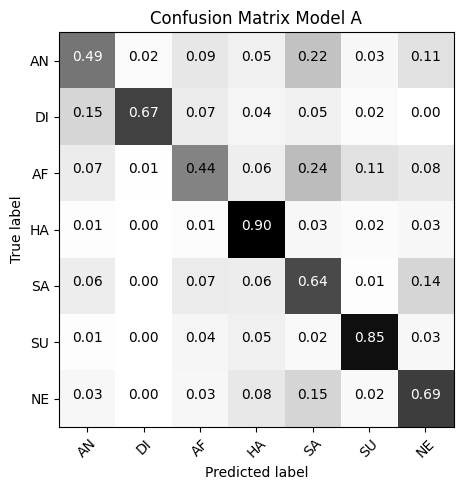

In [31]:
#confusion matrix
y_predict_CNN_A=[]
for i in range (0,np.shape(y_test)[0]):
  y_predict_CNN_A.append(np.argmax(CNN_A.predict(np.expand_dims(X_test[i],0))))
  
print('CONFUSION MATRIX - Model A')
print("________________________________") 
cnf_matrix = confusion_matrix(y_test_numerical, y_predict_CNN_A)
np.set_printoptions(precision=2)


# Plot normalized confusion matrix
plt.figure(figsize=(5,5), dpi=100)
plt.grid(None)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Confusion Matrix Model A')
plt.savefig('Confusion_Matrix_ModelA.tiff')
plt.show()

# Model B

In [16]:
#Model B
def model_B(input_layer):
    B = bloc_conv(input_layer,n_conv_layer=3,n_filter=96,k_size=3)
    B = bloc_conv(B,n_conv_layer=3,n_filter=192,k_size=3)
    B = bloc_conv(B,n_conv_layer=2,n_filter=192,k_size=3,batch_norm =False,maxpool =True, drop=True) 
    B = bloc_conv(B,n_conv_layer=1,n_filter=256,k_size=1,batch_norm =False, maxpool =False,drop=False) 
    B = bloc_conv(B,n_conv_layer=1,n_filter=7,k_size=1,batch_norm =True, maxpool =False,drop=False) 
    B = GlobalAveragePooling2D()(B)
    B = Activation(activation='softmax')(B)
    B = Model(input_layer, B, name='MODEL_B')
    
    return B

CNN_B = model_B(input_layer)

In [17]:
CNN_B.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 48, 48, 96)        960       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 48, 48, 96)        83040     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 48, 48, 96)        83040     
_________________________________________________________________
batch_normalization_4 (Batch (None, 48, 48, 96)        384       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 23, 23, 96)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 23, 23, 96)        0         
__________

In [18]:
CNN_B.compile(loss=categorical_crossentropy, optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), metrics=['acc']) 

''' (to Train)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')
checkpoint = ModelCheckpoint('./weights/best_modelB', monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True, mode='auto', period=1)
CNN_B.fit(X_train, y_train, batch_size=64, epochs=100, verbose=1, 
                        shuffle=True,callbacks=[lr_reducer, early_stopper, checkpoint], 
                        validation_data=(X_val,y_val))
'''

" (to Train)\nlr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)\nearly_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')\ncheckpoint = ModelCheckpoint('./weights/best_modelB', monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True, mode='auto', period=1)\nCNN_B.fit(X_train, y_train, batch_size=64, epochs=100, verbose=1, \n                        shuffle=True,callbacks=[lr_reducer, early_stopper, checkpoint], \n                        validation_data=(X_val,y_val))\n"

In [21]:
CNN_B=load_model('./best_models/ModelB_65,75_-1,07val_67,48_-1,00test.h5')


In [22]:
#Validation set accuracy
_, accuracyB_val = CNN_B.evaluate(X_val, y_val, batch_size=64)
_, accuracyB_test = CNN_B.evaluate(X_test, y_test, batch_size=64)

print('Model B validation accuracy : {} , test accuracy : {}'.format(accuracyB_val, accuracyB_test))

3589/3589 [==============================] - 3s 946us/step
Model B validation accuracy : 0.6575647812802734 , test accuracy : 0.6748397882584577


# Model C

In [23]:
#Model C
def model_C(input_layer):
    C=bloc_conv(input_layer,n_conv_layer=3,n_filter=96,k_size=3)
    C=bloc_conv(C,n_conv_layer=3,n_filter=192,k_size=3)
    C=bloc_conv(C,n_conv_layer=2,n_filter=192,k_size=3,batch_norm =False,maxpool =True, drop=True) 

    C = bloc_conv(C,n_conv_layer=1,n_filter=256,k_size=3,batch_norm =False, maxpool =False, drop=False) 
    C = bloc_conv(C,n_conv_layer=1,n_filter=256,k_size=1,batch_norm =False, maxpool =False,drop= False) 
    C = bloc_conv(C,n_conv_layer=1,n_filter=7,k_size=1,batch_norm =True, maxpool =False,drop=False) 
    C = GlobalAveragePooling2D()(C)
    C = Activation(activation='softmax')(C)
    C = Model(input_layer, C, name='MODEL_C')
    

    return C

CNN_C = model_C(input_layer)

In [24]:
CNN_C.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 48, 48, 96)        960       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 48, 48, 96)        83040     
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 48, 48, 96)        83040     
_________________________________________________________________
batch_normalization_7 (Batch (None, 48, 48, 96)        384       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 23, 23, 96)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 23, 23, 96)        0         
__________

In [25]:
CNN_C.compile(loss=categorical_crossentropy, optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), metrics=['acc']) 

''' (to Train)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')
checkpoint = ModelCheckpoint('./weights/best_modelC', monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True, mode='auto', period=1)
CNN_C.fit(X_train, y_train, batch_size=64, epochs=100, verbose=1, 
                        shuffle=True,callbacks=[lr_reducer, early_stopper, checkpoint], 
                        validation_data=(X_val,y_val))
'''

" (to Train)\nlr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)\nearly_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')\ncheckpoint = ModelCheckpoint('./weights/best_modelC', monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True, mode='auto', period=1)\nCNN_C.fit(X_train, y_train, batch_size=64, epochs=100, verbose=1, \n                        shuffle=True,callbacks=[lr_reducer, early_stopper, checkpoint], \n                        validation_data=(X_val,y_val))\n"

In [26]:
CNN_C=load_model('./best_models/ModelC_65,51_-1,03val_68,15_-0.97test.h5')


In [27]:
#Validation set accuracy
_, accuracyC_val = CNN_C.evaluate(X_val, y_val, batch_size=64)
_, accuracyC_test = CNN_C.evaluate(X_test, y_test, batch_size=64)

print('Model C validation accuracy : {} , test accuracy : {}'.format(accuracyC_val, accuracyC_test))

3589/3589 [==============================] - 3s 961us/step
Model C validation accuracy : 0.6550571189912523 , test accuracy : 0.6815268877456699


# Model D

In [28]:
#Model D
def model_D(input_layer):
    D = bloc_conv(input_layer,n_conv_layer=3,n_filter=96,k_size=3)

    D = bloc_conv(D,n_conv_layer=3,n_filter=192,k_size=3)

    D = bloc_conv(D,n_conv_layer=2,n_filter=192,k_size=3,batch_norm =False,maxpool =True, drop=True) 

    D = bloc_conv(D,n_conv_layer=2,n_filter=256,k_size=3,batch_norm =False, maxpool =False, drop=True) 

    D = bloc_conv(D,n_conv_layer=1,n_filter=512,k_size=1,batch_norm =False, maxpool =False,drop= False) 

    D = bloc_conv(D,n_conv_layer=1,n_filter=7,k_size=1,batch_norm =True, maxpool =False,drop=False) 

    D = GlobalAveragePooling2D()(D)
    D = Activation(activation='softmax')(D)
    D = Model(input_layer, D, name='MODEL_D')
    
    return D

CNN_D = model_D(input_layer)

In [29]:
CNN_D.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 48, 48, 96)        960       
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 48, 48, 96)        83040     
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 48, 48, 96)        83040     
_________________________________________________________________
batch_normalization_10 (Batc (None, 48, 48, 96)        384       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 23, 23, 96)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 23, 23, 96)        0         
__________

In [30]:
CNN_D.compile(loss=categorical_crossentropy, optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), metrics=['acc']) 

''' (to Train)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')
checkpoint = ModelCheckpoint('./weights/best_modelD', monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True, mode='auto', period=1)
CNN_D.fit(X_train, y_train, batch_size=64, epochs=100, verbose=1, 
                        shuffle=True,callbacks=[lr_reducer, early_stopper, checkpoint], 
                        validation_data=(X_val,y_val))
'''

" (to Train)\nlr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1)\nearly_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')\ncheckpoint = ModelCheckpoint('./weights/best_modelD', monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True, mode='auto', period=1)\nCNN_D.fit(X_train, y_train, batch_size=64, epochs=100, verbose=1, \n                        shuffle=True,callbacks=[lr_reducer, early_stopper, checkpoint], \n                        validation_data=(X_val,y_val))\n"

In [31]:
CNN_D=load_model('./best_models/ModelD_67,26_-1,07val_68,15_-0.99test.h5')

In [32]:
#Validation set accuracy
_, accuracyD_val = CNN_D.evaluate(X_val, y_val, batch_size=64)
_, accuracyD_test = CNN_D.evaluate(X_test, y_test, batch_size=64)

print('Model D validation accuracy : {} , test accuracy : {}'.format(accuracyD_val, accuracyD_test))

3589/3589 [==============================] - 4s 995us/step
Model D validation accuracy : 0.6726107550932857 , test accuracy : 0.6815268877456699


# Ensembling

In [35]:
def ensemble_average(models):
    
    outputs_val = [model.predict(X_val) for model in models]
    ensemble_prediction_val=0
    for pred in range(0,len(models)): 
      ensemble_prediction_val +=outputs_val[pred]
    ensemble_prediction_val /=len(models)
    good_pred_val=0
    y_valset=[]
    y_predictionval=[]
    
    for i in range(0,len(ensemble_prediction_val)):
      y_valset.append(np.argmax(y_val[i]))
      y_predictionval.append(np.argmax(ensemble_prediction_val[i]))
      if np.argmax(ensemble_prediction_val[i])==np.argmax(y_val[i]):
        good_pred_val=good_pred_val+1
      else:
        pass
    
    accuracy_val=good_pred_val/len(ensemble_prediction_val)
    
    
    outputs_test = [model.predict(X_test) for model in models]
    ensemble_prediction_test=0
    for pred in range(0,len(models)): 
      ensemble_prediction_test +=outputs_test[pred]
    ensemble_prediction_test /=len(models)
    good_pred_test=0
    y_testset=[]
    y_predictiontest=[]
    
    for i in range(0,len(ensemble_prediction_test)):
      y_testset.append(np.argmax(y_test[i]))
      y_predictiontest.append(np.argmax(ensemble_prediction_test[i]))
      if np.argmax(ensemble_prediction_test[i])==np.argmax(y_test[i]):
        good_pred_test=good_pred_test+1
      else:
        pass
    
    accuracy_test=good_pred_test/len(ensemble_prediction_test)
    return accuracy_val,accuracy_test,y_valset,y_testset,y_predictionval,y_predictiontest

In [36]:
def ensemble_max(models):
    
    outputs_val = [model.predict(X_val) for model in models]
    
    good_pred_val=0
    y_valset=[]
    y_predictionval=[]
    
    for i in range(0,len(y_val)):
      max_predictions=[]
      max_predictions_indexes=[]
      for m in range(0,len(models)): 
        max_predictions.append(np.max(outputs_val[m][i]))
        max_predictions_indexes.append(np.argmax(outputs_val[m][i]))
      y_predictionval.append(max_predictions_indexes[np.argmax(max_predictions)])
      
      y_valset.append(np.argmax(y_val[i]))
      if y_predictionval[i]==y_valset[i]:
        good_pred_val=good_pred_val+1
      else:
        pass
    
    accuracy_val=good_pred_val/len(y_val)
    
    
    outputs_test = [model.predict(X_test) for model in models]
    good_pred_test=0
    y_testset=[]
    y_predictiontest=[]
    
    for i in range(0,len(y_test)):
      max_predictions=[]
      max_predictions_indexes=[]
      for m in range(0,len(models)):
        
        
        max_predictions.append(np.max(outputs_test[m][i]))
        max_predictions_indexes.append(np.argmax(outputs_test[m][i]))
        
      y_predictiontest.append(max_predictions_indexes[np.argmax(max_predictions)])
      
      y_testset.append(np.argmax(y_test[i]))
      if y_predictiontest[i]==y_testset[i]:
        good_pred_test=good_pred_test+1
      else:
        pass
    
    accuracy_test=good_pred_test/len(y_test)
    return accuracy_val,accuracy_test,y_valset,y_testset,y_predictionval,y_predictiontest

In [37]:
Model_AB=[CNN_A,CNN_B]
Model_AC=[CNN_A,CNN_C]
Model_AD=[CNN_A,CNN_D]
Model_BC=[CNN_B,CNN_C]
Model_BD=[CNN_B,CNN_D]
Model_CD=[CNN_C,CNN_D]
Model_ABC=[CNN_A,CNN_B,CNN_C]
Model_ABD=[CNN_A,CNN_B,CNN_D]
Model_BCD=[CNN_B,CNN_C,CNN_D]
Model_ACD=[CNN_A,CNN_C,CNN_D]
Model_ABCD=[CNN_A,CNN_B,CNN_C,CNN_D]

In [38]:
MODELS = [Model_AB, Model_AC, Model_AD, Model_BC, Model_BD, Model_CD, 
          Model_ABC, Model_ABD, Model_BCD, Model_ACD, Model_ABCD]

MODELS_DESCRIPTION = ['Model_AB', 'Model_AC', 'Model_AD', 'Model_BC', 'Model_BD', 'Model_CD', 
          'Model_ABC', 'Model_ABD', 'Model_BCD', 'Model_ACD', 'Model_ABCD']

In [39]:
i=0
for model in MODELS : 
  print("________________________________")
  print('Average Strategy {} : '.format(MODELS_DESCRIPTION[i]))
  acc_val_avg,acc_test_avg,y_val_avg,y_test_avg,y_pred_val_avg,y_pred_test_avg=ensemble_average(model)  
  print('Accuracy Val : {} % | Accuracy Test: {} %'.format(acc_val_avg*100,acc_test_avg*100))
  print("________________________________")
  print('Maximum Strategy {} : '.format(MODELS_DESCRIPTION[i]))
  acc_val_max,acc_test_max,y_val_max,y_test_max,y_pred_val_max,y_pred_test_max=ensemble_max(model)  
  print('Accuracy Val : {} % | Accuracy Test : {} % '.format(acc_val_max*100,acc_test_max*100))
  print("________________________________")
  print("________________________________")
  i+=1


________________________________
Average Strategy Model_AB : 
Accuracy Val : 68.9607132906102 % | Accuracy Test: 70.46531067149624 %
________________________________
Maximum Strategy Model_AB : 
Accuracy Val : 68.65422123154083 % | Accuracy Test : 70.38172192811368 % 
________________________________
________________________________
________________________________
Average Strategy Model_AC : 
Accuracy Val : 68.93285037614935 % | Accuracy Test: 70.91111730286987 %
________________________________
Maximum Strategy Model_AC : 
Accuracy Val : 68.15268877124548 % | Accuracy Test : 70.96684313179159 % 
________________________________
________________________________
________________________________
Average Strategy Model_AD : 
Accuracy Val : 69.76873780997492 % | Accuracy Test: 71.10615770409585 %
________________________________
Maximum Strategy Model_AD : 
Accuracy Val : 69.32293117860128 % | Accuracy Test : 70.54889941487879 % 
________________________________
__________________________